# Homework 01 

This Jupyter Notebook file is a template that we provide for the homework.
You _must_ use this template and follow the instructions.
To unify the submission, we require you to store specific intermediate results into _"submission-variables"_.
These values are printed at the _end_ of the jupyter notebook and will be (partially) used to grade your assignment.
Please ensure that these variables have the correct values and aren't overwritten by following code-cells.

In [52]:
# used for submission variables
from copy import deepcopy
import numpy as np
import geopandas
from pathlib import Path

import osmnx

from sentinelsat import SentinelAPI
from datetime import date

from shapely.geometry import Point
import rasterio
import zipfile

from enum import Enum
from typing import List, Sequence
import matplotlib.pyplot as plt

import rasterio.mask

## Sentinel-2 tile download

Download a Sentinel-2 tile from [SciHub Copernicus](https://scihub.copernicus.eu/dhus/#/home) with the following requirements:
- With the sensing date _after_ 01.03.2022
- With the product-type `S2MSI2A`
- _At least_ a cloud cover percentage of 1% but _no more_ than 20%
- Not the tile with the id: 
    - `6e5ad1c9-fc0e-4b93-9b5c-d0d401673206`

_Write_ down (inside of a markdown cell) a city that is part of the downloaded Sentinel-2 tile!

To ensure that no secrets are shared, please use the following code template.
You can create a [TOML](https://en.wikipedia.org/wiki/TOML) file called `.secrets.toml` with the contents:

```toml

scihub_copernicus_user = "<YOUR_PWD>"
scihub_copernicus_pwd = "<YOUR_PWD>"
```

Or you can simply remove your username/password _after_ executing the notebook and _before_ submitting it.

In [53]:
# KEEP
from dynaconf import Dynaconf

settings = Dynaconf(
    envvar_prefix="IP4RS",
    settings_files=["settings.toml", ".secrets.toml"],
)

SENTINEL_API_URL = "https://scihub.copernicus.eu/dhus"
YOUR_USERNAME = "stahir01"
YOUR_PWD = "CitySchool@0"
user = settings.get("scihub_copernicus_user", default=YOUR_USERNAME)
pwd = settings.get("scihub_copernicus_pwd", default=YOUR_PWD)
assert user != r""
assert pwd != r""
###

In [54]:
api = SentinelAPI(user, pwd, SENTINEL_API_URL)

In [55]:
#Since downloading all files takes a lot of time so we take a specific location so we can filter the results
#Select MarienPlatz as the location
lat = 48.1374
long = 11.5754

location = geopandas.GeoSeries([Point(long, lat)], crs="EPSG:4326")
location = location.to_wkt()[0]
location

'POINT (11.5754 48.1374)'

In [56]:
# Add here the code to select and download the tile

# The tile-id should be generated here
# for example:
start_date = date(year=2022, month=3, day=2)
end_date = date(year=2022, month=5, day=27)
satellite = "Sentinel-2"
product_type = "S2MSI2A"
tile_id = "6e5ad1c9-fc0e-4b93-9b5c-d0d401673206"


tile_results = api.query(location,
                         date=(start_date,end_date), 
                         platformname=satellite, 
                         producttype=product_type,
                         cloudcoverpercentage=(1,20))



#api.download_all(tile_results)
products_df = api.to_geodataframe(tile_results)
assert not products_df.empty
products_df



title  \
df925bf4-4776-43d0-a00f-6f7f948ee6b3  S2A_MSIL2A_20220518T100601_N0400_R022_T32UPU_2...   
b51c2cb9-9d51-4a6d-9550-aee08f675eed  S2A_MSIL2A_20220511T101601_N0400_R065_T32UPU_2...   
b64b232f-92aa-4cc0-9bea-a57db78fc6ca  S2A_MSIL2A_20220421T101601_N0400_R065_T32UPU_2...   
53fbdd03-971c-47b2-ace2-2a7488e10897  S2A_MSIL2A_20220418T100601_N0400_R022_T32UPU_2...   
bafad99e-7aef-4dd8-accb-3b5efa4eef61  S2A_MSIL2A_20220411T101601_N0400_R065_T32UPU_2...   
0b7a8dff-d20d-435e-bdc2-55dc38e33f37  S2A_MSIL2A_20220319T100731_N0400_R022_T32UPU_2...   
46f69138-918f-4b18-8d63-dc241b857eb2  S2A_MSIL2A_20220312T101831_N0400_R065_T32UPU_2...   

                                                                                   link  \
df925bf4-4776-43d0-a00f-6f7f948ee6b3  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
b51c2cb9-9d51-4a6d-9550-aee08f675eed  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
b64b232f-92aa-4cc0-9bea-a57db78fc6ca  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
53fbdd03-971c-47b2-ace2-2a7488e10897  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
bafad99e-7aef-4dd8-accb-3b5efa4eef61  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
0b7a8dff-d20d-435e-bdc2-55dc38e33f37  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
46f69138-918f-4b18-8d63-dc241b857eb2  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
df925bf4-4776-43d0-a00f-6f7f948ee6b3  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
b51c2cb9-9d51-4a6d-9550-aee08f675eed  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
b64b232f-92aa-4cc0-9bea-a57db78fc6ca  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
53fbdd03-971c-47b2-ace2-2a7488e10897  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
bafad99e-7aef-4dd8-accb-3b5efa4eef61  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
0b7a8dff-d20d-435e-bdc2-55dc38e33f37  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
46f69138-918f-4b18-8d63-dc241b857eb2  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
df925bf4-4776-43d0-a00f-6f7f948ee6b3  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
b51c2cb9-9d51-4a6d-9550-aee08f675eed  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
b64b232f-92aa-4cc0-9bea-a57db78fc6ca  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
53fbdd03-971c-47b2-ace2-2a7488e10897  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
bafad99e-7aef-4dd8-accb-3b5efa4eef61  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
0b7a8dff-d20d-435e-bdc2-55dc38e33f37  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
46f69138-918f-4b18-8d63-dc241b857eb2  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                                summary  \
df925bf4-4776-43d0-a00f-6f7f948ee6b3  Date: 2022-05-18T10:06:01.024Z, Instrument: MS...   
b51c2cb9-9d51-4a6d-9550-aee08f675eed  Date: 2022-05-11T10:16:01.024Z, Instrument: MS...   
b64b232f-92aa-4cc0-9bea-a57db78fc6ca  Date: 2022-04-21T10:16:01.025Z, Instrument: MS...   
53fbdd03-971c-47b2-ace2-2a7488e10897  Date: 2022-04-18T10:06:01.024Z, Instrument: MS...   
bafad99e-7aef-4dd8-accb-3b5efa4eef61  Date: 2022-04-11T10:16:01.024Z, Instrument: MS...   
0b7a8dff-d20d-435e-bdc2-55dc38e33f37  Date: 2022-03-19T10:07:31.024Z, Instrument: MS...   
46f69138-918f-4b18-8d63-dc241b857eb2  Date: 2022-03-12T10:18:31.024Z, Instrument: MS...   

                                     ondemand      generationdate  \
df925bf4-4776-43d0-a00f-6f7f948ee6b3    false 2022-05-18 16:28:16   
b51c2cb9-9d51-4a6d-9550-aee08f675eed    false 2022-05-11 17:45:19   
b64b232f-92aa-4cc0-9bea-a57db78fc6ca    false 2022-04-21 13:47:44   
53fbdd03-971c-47b2-ace2-2a7488e10897    false 2022-04-18 13:26:15   
bafad99e-7aef-4dd8-accb-3b5efa4eef61    false 2022-04-11 13:56:51   
0b7a8dff-d20d-435e-bdc2

In [57]:

#Select the following tile
products_df = products_df.head(1)
products_df


#Used to find the link for the file of the tile we're using.
print(products_df.to_string()) 





                                                                                             title                                                                                                link                                                                              link_alternative                                                                                                                 link_icon                                                                                  summary ondemand      generationdate           beginposition             endposition           ingestiondate  orbitnumber  relativeorbitnumber  illuminationazimuthangle  illuminationzenithangle  vegetationpercentage  notvegetatedpercentage  waterpercentage  unclassifiedpercentage  mediumprobacloudspercentage  highprobacloudspercentage  snowicepercentage  cloudcoverpercentage                                            level1cpdiidentifier format processingbaseline platformname                        

In [58]:
#Download the file to the specified folder

#Directory created 
new_dir = Path("./Hw1_file")
new_dir.mkdir(exist_ok=True)


from simple_downloader import download
tile_location = "https://tubcloud.tu-berlin.de/s/nBqEHQ2X9bBtKGH/download/S2A_MSIL2A_20220518T100601_N0400_R022_T32UPU_20220518T162816.zip"
tile_id = download(tile_location,"./Hw1_file/")




Target file already exists!
Will skip download. To force download set `force=True`


In [59]:
### DO NOT EDIT
submission_tile_id = deepcopy(tile_id)
##

## Valid sub-region

From the previously downloaded tile, extract a _valid_ subregion.
Convert the subregion to a `uint8` array without dropping important information (i.e., not simply calling `np.uint8` on the input).

In [60]:
### Add here the code to select a valid subregion
# 1) We select a sub region
# 2) We convert it into unit 8

#We need to first extract the zipfile

from zipfile import ZipFile
zipf = zipfile.ZipFile(submission_tile_id)
zipf.extractall(path="Hw1_file")




In [61]:
hw1_extracted = submission_tile_id.with_suffix(".SAFE")
assert hw1_extracted.exists()

In [62]:
#Accessing multi-dimensional array images

class Band(str, Enum):
 

    B01 = "B01"
    B02 = "B02"
    B03 = "B03"
    B04 = "B04"
    B05 = "B05"
    B06 = "B06"
    B07 = "B07"
    B08 = "B08"
    B8A = "B8A"
    B09 = "B09"
    B10 = "B10"
    B11 = "B11"
    B12 = "B12"

    def __str__(self):
        return self.value

#Read the images
def read_s2_jp2_data(jp2_data_path: Path) -> np.ndarray:
    
    with rasterio.open(jp2_data_path) as data:
        # rasterio is 1-indexed
        return data.read(1)


def _get_all_jp2_files(source_dir: Path, parent_dir: str = "IMG_DATA/R60m") -> List[Path]:
    """
    Given a Sentinel-2 source directory, find all jp2 files that have
    a parent folder named `parent_dir`.
    Usually, it should be the folder `IMG_DATA`, other possible source
    would be the quality masks in `QI_DATA`.
    To not load band multiple times at different resolutions, by default
    the lowest 60m band is loaded.

    Note: Depending on the acquisition date and data type, the structure might be different
    and no sub-directory within `IMG_DATA` exists!
    """
    image_files = list(source_dir.glob(f"**/{parent_dir}/*.jp2"))
    assert len(image_files) > 0
    return image_files


class S2_TileReader:
    def __init__(self, safe_directory: Path, img_data_parent_dir: str = "IMG_DATA/R60m"):
        self.image_files = _get_all_jp2_files(safe_directory, parent_dir=img_data_parent_dir)

    def _get_band_path(self, band: Band) -> Path:
        return [f for f in self.image_files if f"_{band}_" in f.name][0]

    def read_band_data(self, band: Band) -> np.ndarray:
        band_path = self._get_band_path(band)
        return read_s2_jp2_data(band_path)
    


[[   0    0    0 ... 4495 4418 3314]
 [   0    0    0 ... 4504 4514 2470]
 [   0    0    0 ... 5204 4891 2600]
 ...
 [   0    0    0 ... 3363 3578 3516]
 [   0    0    0 ... 3712 3874 3530]
 [   0    0    0 ... 3467 3593 3618]]
(1830, 1830)


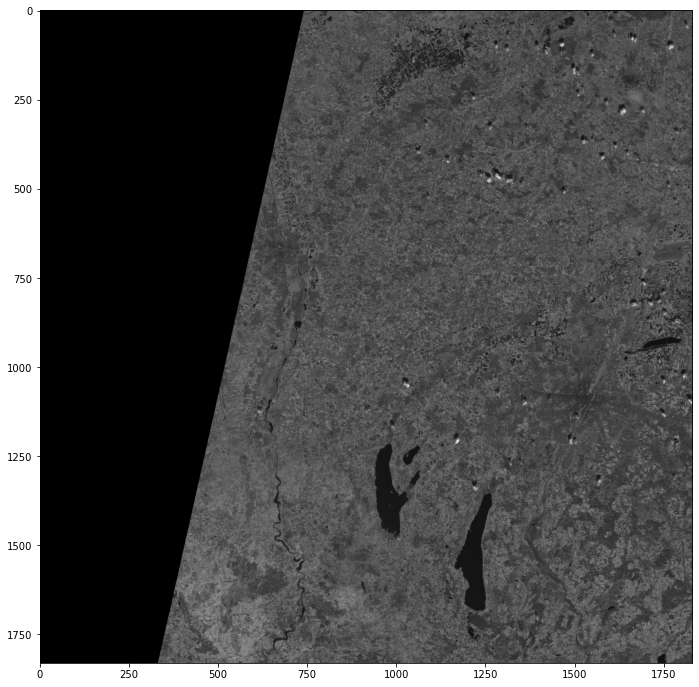

In [63]:
#Visualize a region using Band-B09



tile_reader = S2_TileReader(hw1_extracted)
band05_data = tile_reader.read_band_data(Band.B09)
plt.figure(figsize=(12, 12))
plt.imshow(band05_data, cmap ='gray')
print(band05_data)
print(band05_data.shape)

[[0.         0.         0.         ... 0.3006689  0.29551839 0.22167224]
 [0.         0.         0.         ... 0.3012709  0.3019398  0.16521739]
 [0.         0.         0.         ... 0.34809365 0.32715719 0.17391304]
 ...
 [0.         0.         0.         ... 0.22494983 0.2393311  0.23518395]
 [0.         0.         0.         ... 0.24829431 0.25913043 0.2361204 ]
 [0.         0.         0.         ... 0.23190635 0.24033445 0.24200669]]
(1830, 1830)


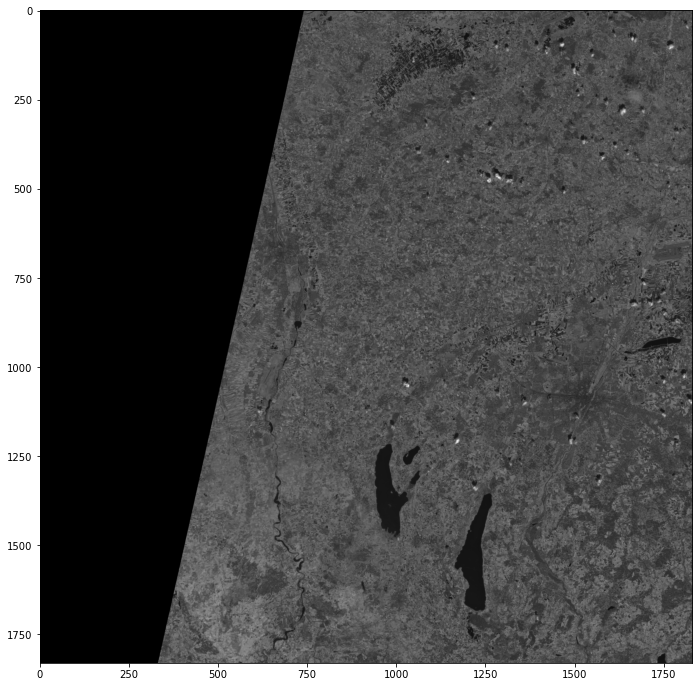

In [64]:
#Normalize the image. 

def normalized_data(data):
    if np.any(data) < 0:
        return 0
    elif np.any(data) > 1:
        return 1
    else:
        return (data - np.min(data)) / (np.max(data) - np.min(data))
    
norm_band05 = normalized_data(band05_data)
print(norm_band05)
print(norm_band05.shape)
plt.figure(figsize=(12, 12))
plt.imshow(norm_band05, cmap ='gray')
    

[[4234 4031 3728 ... 2881 2891 2961]
 [3862 3660 3609 ... 4679 4362 3989]
 [3701 3512 3713 ... 6191 4244 3402]
 ...
 [5146 3170 3066 ... 3363 3578 3516]
 [4668 3508 3094 ... 3712 3874 3530]
 [4027 3423 2866 ... 3467 3593 3618]]
(300, 300)


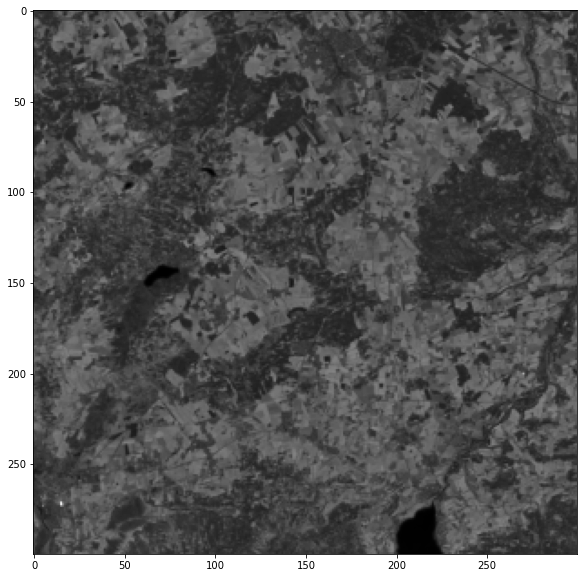

In [65]:
"""
Select a region of an image. We use the original image and not the normalized one.
Reason: Because we will normalize the array when we convert to unit8. Hence, the above normalization part was used for understanding
"""




sub_region = band05_data[-300:, -300:]
plt.figure(figsize=(10, 10))
plt.imshow(sub_region, cmap = "gray")
print(sub_region)
print(sub_region.shape)




In [66]:
#convert it into unit8.
def convert_unit8(img):
    norm_img = (img + 1_000) / 10_000
    # Normalize image between 0 & 1
    norm_img = np.clip(norm_img, 0.0, 1.0)
    unit8 = np.uint8(norm_img * 255)
    return unit8
    
    
subregion_uint8 = convert_unit8(sub_region)
print(subregion_uint8)
print(subregion_uint8.shape)




[[133 128 120 ...  98  99 101]
 [123 118 117 ... 144 136 127]
 [119 115 120 ... 183 133 112]
 ...
 [156 106 103 ... 111 116 115]
 [144 114 104 ... 120 124 115]
 [128 112  98 ... 113 117 117]]
(300, 300)


In [67]:
### DO NOT EDIT
submission_subregion_uint8 = deepcopy(subregion_uint8)
###

### Visualize the valid sub-region

Visualize a _single band_ from the valid subregion _without_ applying any explicit or implicit normalization strategy.
The input array passed to `plt.imshow` has to be in the range `[0, 255]`. This range should also be reflected in the `vmin/vmax` parameters.

In [77]:
# For this section we use the algorithm provided to us to visualize a single band


multi_band = np.stack(
    [tile_reader.read_band_data(b) for b in (Band.B05, Band.B06, Band.B02)],
    axis=-1,
)

#print(single_band, single_band.shape)


#We select the subregion
multi_band_sregion = multi_band[-300:, -300:]


#Select the single band
single_band = multi_band_sregion[:,:, 1]
#print(single_band, single_band .shape)
#plt.figure(figsize=(13, 13))
#plt.imshow(single_band, cmap = "YlGn")




#Convert to unit8
single_band_unit8 = convert_unit8(single_band)
print(single_band_unit8, single_band_unit8.shape)









[[117 111 102 ...  90  91  90]
 [106 101 102 ... 127 122 119]
 [102 101 106 ... 159 117 106]
 ...
 [135  90  91 ...  97 103  99]
 [127 102  88 ... 105 109 100]
 [112 101  85 ...  98 104 106]] (300, 300)


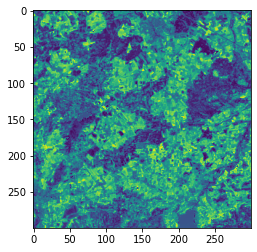

In [78]:
def contrast_adjusement(data, fmin, fmax):
    contrast_image = 255 * ((data - fmin) / (fmax - fmin))
    return contrast_image

#Choose fmin & fmax values in such a way so that scale can be expanded to the maximum extent
single_band_contrast = contrast_adjusement(single_band_unit8, 80, 180)
single_band_contrast.min(), single_band_contrast.max()


#asingle_band_contrast = np.clip(single_band_contrast, 0, 255)

# convert it back to uint8
imshow_inp = np.uint8(single_band_contrast)
plt.imshow(imshow_inp)


In [79]:
# DO NOT EDIT
submission_imshow_inp = deepcopy(imshow_inp)
###

## Morphological operators & Thresholding

The goal of this section is to combine morphological operators with thresholding strategies to create a binary/output mask that can then be used to segment the region/object of interest.
You are _not_ required to perfectly segment the object of interest. It is sufficient if the visual results _indicate_ the object of interest.

You have to meet the following requirements:
- You are _not_ allowed to use simple rectangular structuring elements.
- The values of the output mask must either be 0 or 1
    - 0 is used to indicate the absence of the object
    - 1 is used to indicate the presence of the object

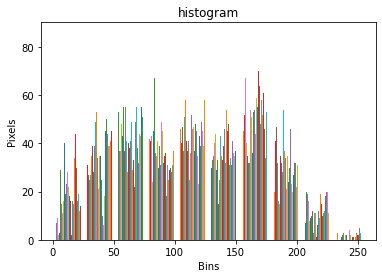

<Figure size 936x936 with 0 Axes>

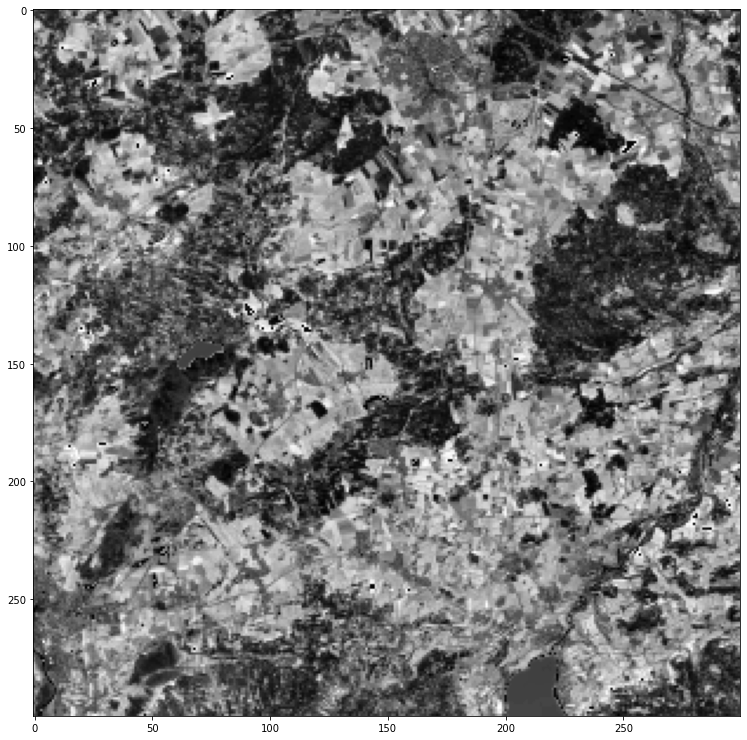

In [80]:
from scipy import ndimage

#Image from previous aprt
org_img = submission_imshow_inp.copy()




#Histogram of the image from previous part
plt.hist(org_img)
plt.title("histogram")
plt.xlabel("Bins")
plt.ylabel("Pixels")
plt.figure(figsize=(13,13))
plt.show()
plt.figure(figsize=(13,13))
plt.imshow(org_img, cmap = "gray")








[[  0   0   0 ...   0   0   0]
 [  0   0   0 ... 119 107   0]
 [  0   0   0 ... 201   0   0]
 ...
 [140   0   0 ...   0   0   0]
 [119   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


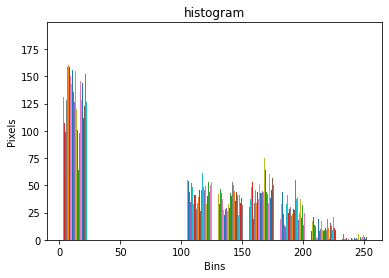

<Figure size 720x720 with 0 Axes>

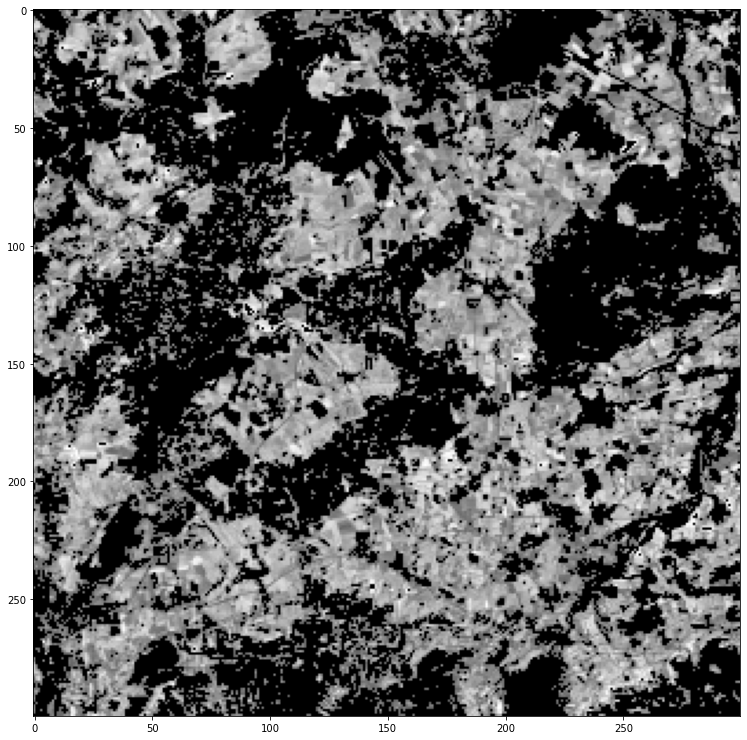

In [81]:
#for i in org_img:
 #   for j in i:
  #      print(j, end = " ")


#All values lesser than 170 should go to zero while other should stay the same
threshold_img = np.where(org_img  < 100, 0, org_img) 
#threshold_img = np.logical_and(np.where(org_img  < 50, 0, org_img), np.where(org_img  > 150, 0, org_img)) 
print(threshold_img)
#for i in threshold_img: 
#    for j in i:
#        print(j, end = " ") 
        
#plt.hist(threshold_img, bins = [0,10,20,30,40,50,60,70,80,90,100, 110, 120, 130, 140, 150])
plt.hist(threshold_img)
plt.title("histogram")
plt.xlabel("Bins")
plt.ylabel("Pixels")
plt.figure(figsize=(10,10))
plt.show()
plt.figure(figsize=(13,13))
plt.imshow(threshold_img, cmap = "gray")



[[0. 1. 0. 0.]
 [1. 1. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 1. 0. 0.]
 [1. 1. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


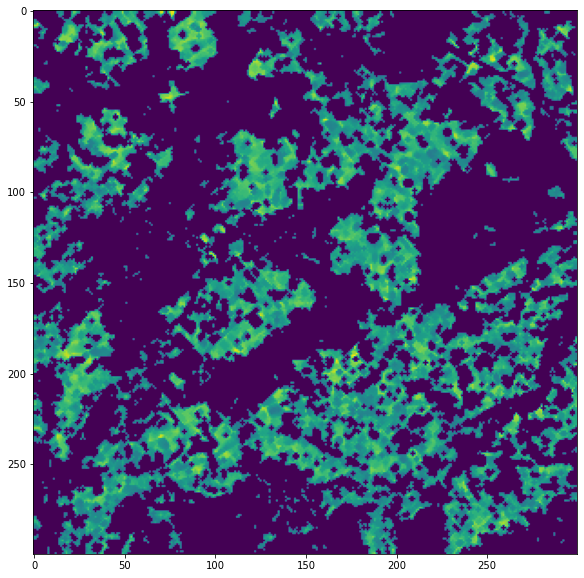

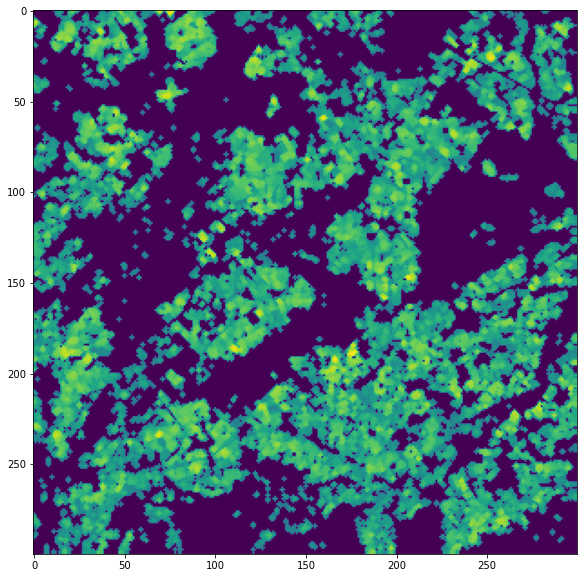

In [84]:
# Opening
from scipy import ndimage

#Kernel
struc_element = np.zeros((4,4,))
struc_element[0,1] = 1
struc_element[1,0] = 1
struc_element[2,1] = 1
struc_element[1,2] = 1
struc_element[1,1] = 1
print(struc_element)
"""
#Kernel
struc_element = np.zeros((5,5,))
struc_element[0,2] = 1
struc_element[1,1] = 1
struc_element[2,0] = 1
struc_element[3,1] = 1
struc_element[4,2] = 1
struc_element[3,3] = 1
struc_element[2,4] = 1
struc_element[1,3] = 1
struc_element[1,2] = 1
struc_element[2,1] = 1
struc_element[2,2] = 1
struc_element[2,3] = 1
struc_element[3,2] = 1

"""
print(struc_element)




#Erosion
erod_img = ndimage.grey_erosion(threshold_img, footprint=struc_element) 
print(erod_img)
plt.figure(figsize=(10,10))
plt.imshow(erod_img)

#Dilation 
dil_img = ndimage.grey_dilation(erod_img, footprint=struc_element)
print(dil_img)
plt.figure(figsize=(10,10))
plt.imshow(dil_img)




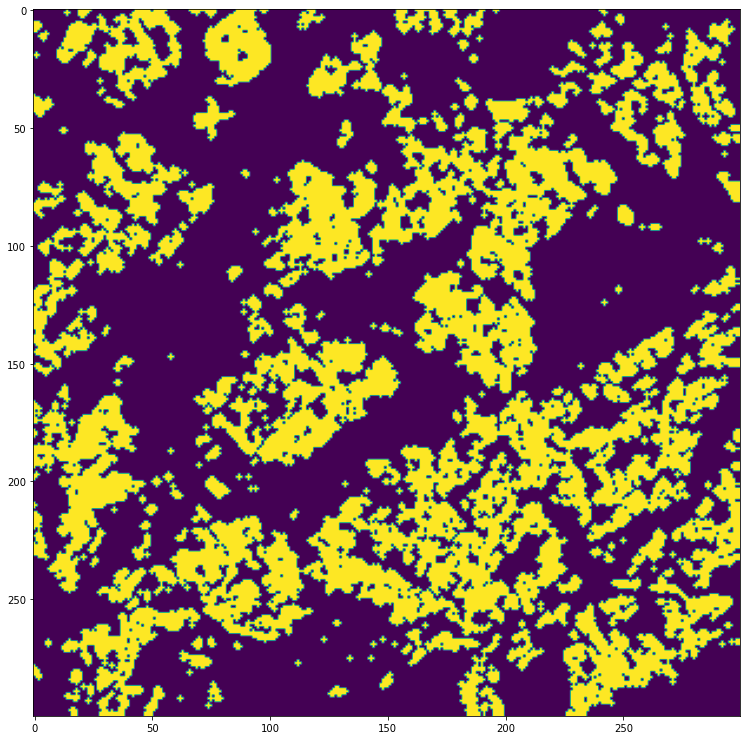

In [88]:
"""
To further visualize the regions we want to focus on, we created another threshold where make sure that all the values below a certain region goes to zero
while others go to 255.
"""
thres_img_opening = np.where(dil_img < 130, 0, 255)
plt.figure(figsize=(13,13))
plt.imshow(thres_img_opening)

output_mask = thres_img_opening 



In [89]:
# DO NOT EDIT
submission_output_mask = deepcopy(output_mask)
###

To visually evaluate your result, use the output mask as an overlay for the RGB channels of the input array.
The colored output should be normalized to enhance the viewing experiment.
You can choose any _valid_ normalization strategy/method for the RGB channels.

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


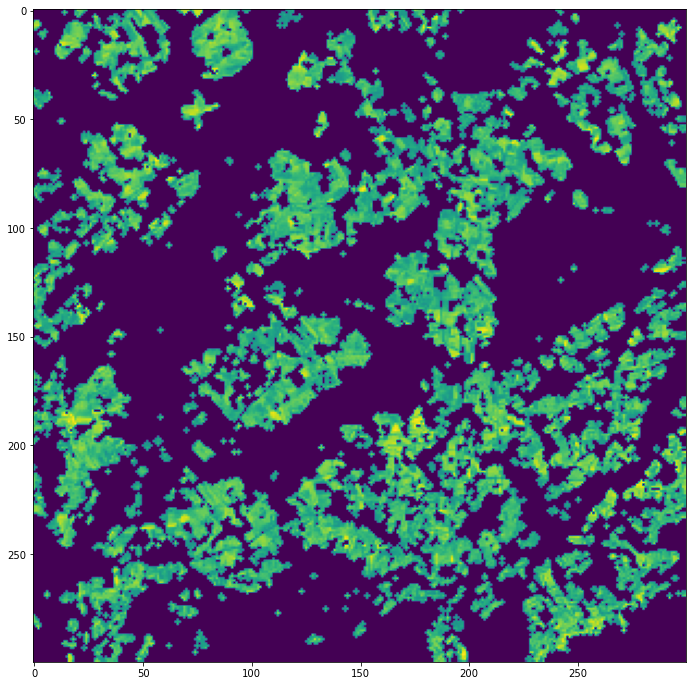

In [98]:
"""
To see what is located in our region of interests. We make all the 255 values equal to 1 while others go to zero. Then we multiply this matrix with
the matrix of the original image so we can see what's is located in our region of interest
"""

arr_prevpart = submission_output_mask.copy()
print(arr_prevpart)\

#Now we have the original image for the focused region
final_img = np.where(arr_prevpart  == 255, 1, 0)
reg_interest = final_img * org_img 
#for i in output_mask:
 #   for j in i:
 #       print(j, end = " ")
plt.figure(figsize=(12,12))
plt.imshow(reg_interest)


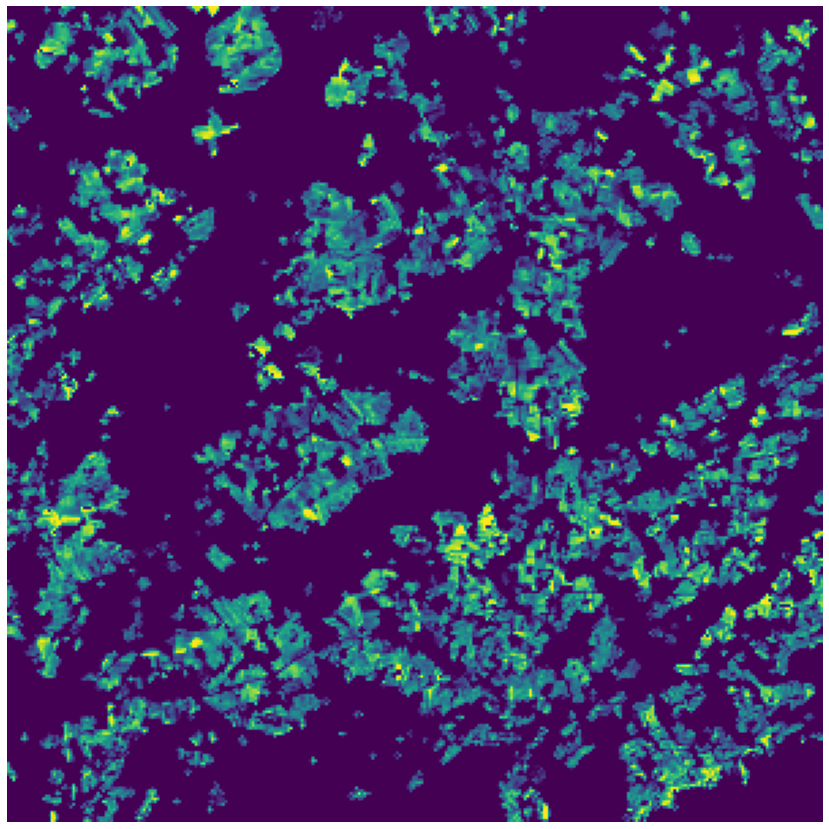

In [100]:
#To further normalize and visualize the image, we use normalization and visualiation code provided to us in the lab
def quant_norm_data(
    data: np.ndarray, lower_quant: float = 0.01, upper_quant: float = 0.99
) -> np.ndarray:
    """
    Normalize the data by quantiles `lower_quant/upper_quant`.
    The quantiles are calculated globally/*across all channels*.
    """
    # Mask an array where equal to a given value.
    masked_data = np.ma.masked_equal(data, 0)
    #Now we take the data and find the lower and upper quartile
    #Masked_data.compressed: Converts data into 1D array
    lq, uq = np.quantile(masked_data.compressed(), (lower_quant, upper_quant))
    #Given an interval, values outside the interval are clipped to the interval edges. 
    #For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.
    data = np.clip(data, a_min=lq, a_max=uq)
    data = (data - lq) / (uq - lq)
    return data


def vis(data: np.ndarray, quant_norm: bool = True):
    """
    Visualize an array by calling `imshow` with `cmap="gray"`.
    By default, the image is normalized through `quant_norm_data`.
    """
    #So we visualize the normalize data
    if quant_norm:
        data = quant_norm_data(data)

    plt.figure(figsize=(15, 15))
    plt.axis("off")
    plt.imshow(data)


vis(reg_interest)

### Discussion

Discuss what you have learned when applying the morphological operators and thresholding strategies.
What didn't work? What issues did you have? What helped?
How did you decide to use the variables you have chosen?

It is not necessary to give an in-depth discussion about each value.
It should be clear, however, that you have tried different configurations and why you have decided on the current configuration.

Here you should write discussion: 

What I tried to do is to first visualize the histogram for the image I imported from the previous part. How the pixels/values are distributed.
Since the majority of my image had a lot of dark regions and some very high values. So values lesser than a certain threshold were removed. I faced some problems while creating a for and an if loop. It told me to use if.any() but even that converted by 2D array into 1D. Hence, in the end, I decided to use np. where since all other methods failed
After that, I used the idea of Opening(dilation followed by erosion). To further see the region of interest, I threshold the image again, however, since I wanted to focus on certain regions, I converted all regions that I want to see to 255 while others were set to zero. 

To get the original RGB image, all 255 values were converted to 1, while others were set to zero. Then the original image's matrix was multiplied by the threshold matrix. Regarding Kernal/structuring element, I tried various
kernels. I tried a 5x5 diamond, 3x3 square; however, I end up using a 3x3 diamond as it worked well with erosion and dilatio

## Submission

- Follow the instructions mentioned in this notebook.
- You are _not_ allowed to install other libraries.
    - The submitted jupyter notebook should be able to run as-is on paperspace and/or the provided Docker image.
- Explain the steps that went into the decision making of the specific values.
- It is essential that each homework should be done individually!
- The notebook should have been executed once before submitting it
    - The notebook should _not_ be _cleaned_ before submitting

Each student should submit the following materials to the ISIS system:
- One `zip` file containing the jupyter notebook named as: `IP4RS2022-HW1_<NAME_SURNAME>.zip`



### Submission variables

Please ensure that these variables are correct after you have restarted your notebook and executed all cells from top to bottom.
You are _not allowed_ to modify the following cells:

In [101]:
import rich

rich.print(f"{submission_tile_id=}")
rich.print(f"{submission_subregion_uint8=}")
rich.print(f"{submission_output_mask=}")

submission_tile_id=PosixPath('Hw1_file/S2A_MSIL2A_20220518T100601_N0400_R022_T32UPU_20220518T
162816.zip')

submission_subregion_uint8=array([[133, 128, 120, ...,  98,  99, 101],
       [123, 118, 117, ..., 144, 136, 127],
       [119, 115, 120, ..., 183, 133, 112],
       ...,
       [156, 106, 103, ..., 111, 116, 115],
       [144, 114, 104, ..., 120, 124, 115],
       [128, 112,  98, ..., 113, 117, 117]], dtype=uint8)

submission_output_mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])